TP 1 NLP Rakotonanahary Dorian et Hollier-Larousse Nicolas INGE 3D


Le dataset est disponible à cette adresse : https://www.kaggle.com/datasets/dargolex/french-reviews-on-movies-and-en-translation

#### Importation des bibliothèques nécessaires

In [1]:
#Importation des bibliothèques nécessaires

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

#Téléchargement stop words et ressources NLTK

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#### Chargement de données nécessaires pour la visualisation et le modèle

In [2]:
#Chargement du dataset
file_path = 'french_to_english_movies.csv'
data = pd.read_csv(file_path, header=None, names=['text', 'label', 'translation'])
 
#Rename des colonnes
data.rename(columns={'text': 'rating', 'label': 'review'}, inplace=True)
 
#Focus sur les colonnes rating et review uniquement
data = data[['rating', 'review']]
 
#Convertir la colonne 'rating' en valeurs numériques 
data['rating'] = data['rating'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
 
#Séparer les valeurs 0 et 1 dans des dataFrames distincts
data_0 = data[data['rating'] == 0]
data_1 = data[data['rating'] == 1]
 
#Prendre un échantillon aléatoire de 2500 lignes de chaque classe
sample_0 = data_0.sample(n=20000, random_state=42)
sample_1 = data_1.sample(n=20000, random_state=42)
 
#Fuse and merge les échantillons pour obtenir  40000 lignes
data_balanced = pd.concat([sample_0, sample_1]).sample(frac=1, random_state=42).reset_index(drop=True)
 
#Affichage du résultat
print(data_balanced['rating'].value_counts())
print(data_balanced.head())

rating
1    20000
0    20000
Name: count, dtype: int64
   rating                                             review
0       1  "Hangover Square" pourrait n'être qu'un simple...
1       0  Ce film est comme un roman de gare : c'est un ...
2       1  Il est très difficile de juger ce film. Car il...
3       0  Magnifiques paysages et une mère un peu décalé...
4       1  Malgré les années qui passent, ce film culte r...


In [3]:
print(data_balanced.info())
(data_balanced.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  40000 non-null  int32 
 1   review  40000 non-null  object
dtypes: int32(1), object(1)
memory usage: 468.9+ KB
None


,rating,review
0,1,"""Hangover Square"" pourrait n'être qu'un simple..."
1,0,Ce film est comme un roman de gare : c'est un ...
2,1,Il est très difficile de juger ce film. Car il...
3,0,Magnifiques paysages et une mère un peu décalé...
4,1,"Malgré les années qui passent, ce film culte r..."


#### Nettoyage du Dataset

In [5]:
#init mot_in_dict et sac_de_mot
mot_in_dict = set([word.lower() for word in data_balanced['review'].astype(str).str.split().explode().unique()])
sac_de_mot = list(mot_in_dict)
 
#cleanning des données en utilisant mot_in_dict
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Retirer les caractères non alphabétiques
    text = text.lower()  # Convertir en minuscule
    text = nltk.word_tokenize(text)  # Tokenisation
    text = [word for word in text if word in mot_in_dict and word not in stopwords.words('french')]  # Retirer les stop words
    text = [PorterStemmer().stem(word) for word in text]  # Stemming
    return ' '.join(text)
 
data_balanced['clean_text'] = data_balanced['review'].apply(clean_text)
 
#Viz après nettoyage
print(data_balanced['clean_text'].head())

0    squar pourrait tre simpl film noir pur ju fact...
1    film comm roman gare film dimanch donnent vrai...
2    tr difficil juger film car appui base e max a ...
3    magnifiqu paysag re peu cal e rapport doit fui...
4    ann passent film cult rest air inoubli bonheur...
Name: clean_text, dtype: object


#### Visualisation de la Fréquence de mots après Traitement

In [13]:
from nltk import FreqDist

# Fonction pour créer le sac de mots et obtenir les mots les plus fréquents
def sac_de_mots(list_clean_text):
    all_words = []
    for text in list_clean_text:
        # Split le texte en mots et ajoute les mots à all_words
        all_words.extend(text.split())
    # Calcul des fréquences des mots
    all_words_freq = FreqDist(all_words)
    return all_words_freq

# Application de la fonction sur la colonne 'clean_text'
sac_mots = sac_de_mots(data_balanced['clean_text'])

# Afficher les 15 mots les plus fréquents
print(sac_mots.most_common(50))

[('film', 61676), ('r', 40976), ('a', 38747), ('tout', 22049), ('plu', 21770), ('tr', 20583), ('sc', 20012), ('e', 18140), ('bien', 18003), ('re', 16958), ('fait', 12245), ('tre', 11469), ('histoir', 11020), ('san', 10995), ('comm', 10863), ('acteur', 10598), ('si', 10023), ('bon', 9877), ('pr', 9603), ('peu', 9553), ('cett', 9178), ('grand', 8747), ('voir', 8477), ('personnag', 8382), ('aussi', 7919), ('vraiment', 6786), ('fair', 6782), ('autr', 6654), ('rien', 6420), ('peut', 6208), ('g', 6101), ('int', 6058), ('trop', 5935), ('o', 5856), ('petit', 5742), ('quelqu', 5349), ('fin', 5204), ('entr', 5200), ('deux', 5145), ('mal', 5114), ('h', 5057), ('com', 5038), ('p', 4979), ('foi', 4971), ('ne', 4768), ('tou', 4748), ('v', 4725), ('encor', 4718), ('assez', 4567), ('car', 4467)]


<Axes: xlabel='Samples', ylabel='Counts'>

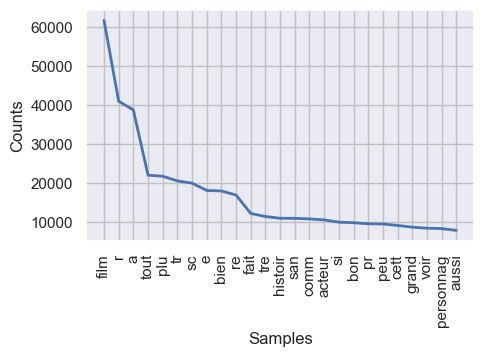

In [14]:
import seaborn as sns
sns.set()
ax = plt.figure(figsize = (5,3))
freqdist = FreqDist(sac_mots)
freqdist.plot(25)

#### World2Vec et Evaluation du score du modèle

c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 100, 100)       │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100, 32)        │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,777 (413.19 KB)

 Trainable params: 105,777 (413.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 43s 86ms/step - accuracy: 0.6082 - loss: 0.6502 - val_accuracy: 0.6159 - val_loss: 0.6351
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.6215 - loss: 0.6342 - val_accuracy: 0.6503 - val_loss: 0.6194
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.6080 - loss: 0.6370 - val_accuracy: 0.6272 - val_loss: 0.6422
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.6341 - loss: 0.6272 - val_accuracy: 0.8128 - val_loss: 0.4505
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.8409 - loss: 0.3899 - val_accuracy: 0.8737 - val_loss: 0.2959
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.8751 - loss: 0.3027 - val_accuracy: 0.8809 - val_loss: 0.2857
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.8830 - loss: 0.2796 - val_accuracy: 0.8934 - val_loss: 0.2661
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.8931 - loss: 0.2642 - 

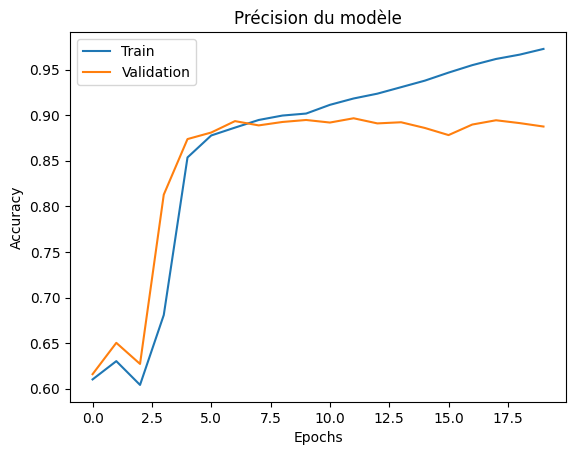

In [10]:
#init embeddings word2Vec
sentences = [nltk.word_tokenize(text) for text in data_balanced['clean_text']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
 
#Préparation des données pour training
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
data_balanced['tokens'] = data_balanced['clean_text'].apply(lambda x: tokenizer.tokenize(x))
X = data_balanced['tokens']
y = data_balanced['rating']  # Variable de sortie corrigée
 
#Transformation des données avec sac_de_mot
X_vectorized = [
    [word2vec_model.wv[word] if word in word2vec_model.wv else np.zeros(100) for word in text] 
    if len(text) > 0 else [np.zeros(100)]  # Assure qu'il y ait au moins un vecteur nul si la liste est vide
    for text in X
]
 
# Chaque séquence est limitée à 100 mots (en tronquant ou en ajoutant des zéros si nécessaire)
X_padded = np.array([np.pad(x, ((0, max(0, 100 - len(x))), (0, 0)), 'constant', constant_values=0)[:100] for x in X_vectorized])
 
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)
 
#Construction du modèle LSTM empilé
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(100, 100)))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
 
#Training du modèle
history = model.fit(X_train, np.array(y_train), epochs=20, batch_size=64, validation_split=0.1)
 
#Viz des performances
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()